# Good Demo: Modular DSPy Agent Architecture

## Production-Grade Analytics with Semantic Layer

This notebook demonstrates the **correct** way to build LLM-powered analytics:

### Architecture Principles

1. **Semantic Layer First**: All metrics defined in `config/semantic.yml` with tested SQL
2. **Modular Agents**: Small, focused, testable components with clear contracts
3. **Local-First Logic**: Deterministic rules wherever possible; LLM only for ambiguity
4. **DSPy Signatures**: Structured prompts that are declarative and optimizable
5. **Observability**: Every decision logged with run_id, timings, and provenance

### Business Question

"Which channel mix change is most likely to improve CAC next month, given a recent anomaly in referral traffic?"

### Agent Pipeline

```
Question → Triage → Text-to-Semantic → Metric Compilation → Execution → 
          Hypothesis Simulation → Narration → Observability
```

## 1. Bootstrap: Environment and Database

In [1]:
# Core imports
import sys
import os
from pathlib import Path

# Add utils to path
sys.path.insert(0, str(Path.cwd()))

# Standard libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any, List, Optional

# Our utilities
from utils import (
    load_environment,
    get_db_connection,
    validate_schema,
    SemanticLayer,
    plot_channel_metric,
    RunRecord
)

# DSPy and OpenAI
import dspy
from openai import OpenAI

print("✓ Imports successful")

✓ Imports successful


In [2]:
# Load environment
env_config = load_environment()
print("Environment loaded:")
print(f"  Model: {env_config['OPENAI_MODEL']}")
print(f"  DB Path: {env_config['DB_PATH']}")
print(f"  API Key: {env_config['OPENAI_API_KEY'][:8]}...")

# Configure OpenAI
openai_client = OpenAI(api_key=env_config['OPENAI_API_KEY'])

# Configure DSPy
lm = dspy.LM(f"openai/{env_config['OPENAI_MODEL']}", api_key=env_config['OPENAI_API_KEY'])
dspy.settings.configure(lm=lm)

print("\n✓ LLM configured")

Environment loaded:
  Model: gpt-4o-mini
  DB Path: ../data/synthetic_data.duckdb
  API Key: sk-proj-...

✓ LLM configured


In [3]:
# Connect to database (read-only mode)
db_path = env_config['DB_PATH']
conn = get_db_connection(db_path, read_only=True)
print(f"✓ Connected to database: {db_path}")

# Validate schema
schema_validation = validate_schema(conn)
print(f"\n✓ Schema validation passed")
print(f"  Tables found: {len(schema_validation['tables'])}")
for table in sorted(schema_validation['tables']):
    print(f"    - {table}")

✓ Connected to database: ../data/synthetic_data.duckdb

✓ Schema validation passed
  Tables found: 8
    - dim_adgroups
    - dim_campaigns
    - dim_creatives
    - dim_customers
    - dim_products
    - fact_ad_spend
    - fact_orders
    - fact_sessions


In [4]:
# Set defaults for the session
DEFAULT_WINDOW_DAYS = 90
DEFAULT_LIMIT = 1000
OFFLINE_MODE = False  # Set to True to disable LLM calls for rehearsals

print("Session defaults:")
print(f"  Window: {DEFAULT_WINDOW_DAYS} days")
print(f"  Limit: {DEFAULT_LIMIT} rows")
print(f"  Offline mode: {OFFLINE_MODE}")

Session defaults:
  Window: 90 days
  Limit: 1000 rows
  Offline mode: False


## 2. Semantic Catalogue

Load the semantic layer that defines:
- Canonical dimensions (channel, campaign_name, device, region)
- Safe base queries (spend, conversions, revenue by channel)
- Derived metrics (ROAS, CAC by channel)
- Join rules (revenue attribution path)

In [5]:
# Load semantic layer
semantic = SemanticLayer('../config/semantic.yml')
print("✓ Semantic layer loaded")
print(f"  Spec version: {semantic.config.get('version')}")
print(f"  Spec hash: {semantic.spec_hash}")
print(f"\n{semantic.describe_catalogue()}")

✓ Semantic layer loaded
  Spec version: 1.0.0
  Spec hash: 3adeb316e50a

SEMANTIC CATALOGUE

Dimensions:
  • channel: dim_campaigns.channel
    Marketing channel (e.g., search, social, referral, display)
  • campaign_name: dim_campaigns.campaign_name
    Campaign identifier
  • device: fact_sessions.device_type
    Device type (desktop, mobile, tablet)
  • region: dim_customers.region
    Geographic region

Base Queries:
  • spend_by_channel: Total ad spend by channel
  • impressions_clicks_by_channel: Impressions and clicks by channel
  • conversions_by_channel: Conversions by channel (from sessions)
  • revenue_by_channel: Revenue by channel using last-touch attribution (fact_orders -> fact_sessions -> dim_campaigns)

Derived Metrics:
  • roas_by_channel: Return on ad spend by channel (revenue / spend)
  • cac_by_channel: Customer acquisition cost by channel (spend / conversions)

Key Join Rules:
  • revenue_attribution: Revenue must be attributed via last-touch: fact_orders -> fact_

In [6]:
# Show key metric definitions
print("\nCanonical Metric Definitions:")
print("=" * 60)
for metric, formula in semantic.get_metric_definitions().items():
    print(f"  {metric:15} = {formula}")


Canonical Metric Definitions:
  spend           = SUM(fact_ad_spend.spend)
  impressions     = SUM(fact_ad_spend.impressions)
  clicks          = SUM(fact_ad_spend.clicks)
  ctr             = clicks / NULLIF(impressions, 0)
  sessions        = COUNT(*) FROM fact_sessions
  conversions     = SUM(CASE WHEN converted_flag THEN 1 ELSE 0 END)
  cvr             = conversions / NULLIF(sessions, 0)
  orders          = COUNT(DISTINCT fact_orders.order_id)
  revenue         = SUM(fact_orders.revenue)
  roas            = revenue / NULLIF(spend, 0)
  cac             = spend / NULLIF(conversions, 0)


In [7]:
# Show join rules (critical for correctness)
print("\nJoin Rules (Revenue Attribution):")
print("=" * 60)
join_rules = semantic.get_join_rules()
revenue_rule = join_rules.get('revenue_attribution', {})
print(f"Rule: {revenue_rule.get('description')}")
print("Path:")
for step in revenue_rule.get('path', []):
    print(f"  → {step}")
print("\n⚠️ This is enforced in semantic.yml queries; LLM cannot override it")


Join Rules (Revenue Attribution):
Rule: Revenue must be attributed via last-touch: fact_orders -> fact_sessions -> dim_campaigns
Path:
  → fact_orders.session_id = fact_sessions.session_id
  → fact_sessions.campaign_id = dim_campaigns.campaign_id

⚠️ This is enforced in semantic.yml queries; LLM cannot override it


## 3. Agent Architecture with DSPy

Define agents as **DSPy signatures** with clear input/output contracts.

### Agent Roles

1. **TriageAgent**: Classify question type (search vs analysis)
2. **TextToSemanticAgent**: Map natural language to semantic request
3. **MetricRunner**: Compile and execute queries (deterministic)
4. **HypothesisAgent**: Simulate budget scenarios (deterministic)
5. **NarratorAgent**: Generate decision memo with constraints

### Design Principles

- **Local rules first**: Use keywords/templates before LLM
- **Fallback only**: LLM called only when confidence < threshold
- **Validated outputs**: All LLM outputs validated against semantic layer
- **Observable**: Every decision logged with confidence and reasoning

In [8]:
# DSPy Signatures

class TriageSignature(dspy.Signature):
    """Classify a user question as search or analysis."""
    question: str = dspy.InputField(desc="User's business question")
    mode: str = dspy.OutputField(desc="Either 'search' or 'analysis'")
    confidence: float = dspy.OutputField(desc="Confidence score 0-1")
    reason: str = dspy.OutputField(desc="Brief explanation of classification")


class TextToSemanticSignature(dspy.Signature):
    """Map natural language question to semantic request."""
    question: str = dspy.InputField(desc="User's business question")
    available_metrics: str = dspy.InputField(desc="List of available metrics")
    available_dimensions: str = dspy.InputField(desc="List of available dimensions")
    metric: str = dspy.OutputField(desc="Selected metric name")
    dimensions: str = dspy.OutputField(desc="Comma-separated dimension names")
    filters: str = dspy.OutputField(desc="Optional filters as JSON")
    window_days: int = dspy.OutputField(desc="Time window in days")


class NarratorSignature(dspy.Signature):
    """Generate concise decision memo from analysis results."""
    question: str = dspy.InputField(desc="Original business question")
    metrics_used: str = dspy.InputField(desc="Metrics that were queried")
    key_findings: str = dspy.InputField(desc="Key data findings")
    recommendation: str = dspy.InputField(desc="Proposed action with confidence interval")
    memo: str = dspy.OutputField(desc="Decision memo (max 150 words) with risks and next steps")


print("✓ DSPy signatures defined")

✓ DSPy signatures defined


In [9]:
# Agent Implementations

class TriageAgent:
    """Classify questions as search or analysis."""
    
    def __init__(self, offline_mode: bool = False):
        self.offline_mode = offline_mode
        self.predictor = dspy.Predict(TriageSignature)
        
        # Local keyword rules
        self.analysis_keywords = [
            'cac', 'roas', 'improve', 'optimize', 'compare', 'which',
            'recommend', 'should', 'best', 'worst', 'trend', 'anomaly'
        ]
        self.search_keywords = [
            'what is', 'show me', 'list', 'find', 'get', 'display'
        ]
    
    def __call__(self, question: str) -> Dict[str, Any]:
        question_lower = question.lower()
        
        # Try local rules first
        analysis_score = sum(1 for kw in self.analysis_keywords if kw in question_lower)
        search_score = sum(1 for kw in self.search_keywords if kw in question_lower)
        
        if analysis_score > search_score and analysis_score >= 2:
            return {
                'mode': 'analysis',
                'confidence': 0.9,
                'reason': f'Matched {analysis_score} analysis keywords',
                'method': 'local_rules'
            }
        elif search_score > analysis_score and search_score >= 2:
            return {
                'mode': 'search',
                'confidence': 0.9,
                'reason': f'Matched {search_score} search keywords',
                'method': 'local_rules'
            }
        
        # Fallback to LLM
        if self.offline_mode:
            return {
                'mode': 'analysis',
                'confidence': 0.5,
                'reason': 'Default in offline mode',
                'method': 'offline_default'
            }
        
        result = self.predictor(question=question)
        return {
            'mode': result.mode,
            'confidence': float(result.confidence),
            'reason': result.reason,
            'method': 'dspy_fallback'
        }


class TextToSemanticAgent:
    """Map natural language to semantic request."""
    
    def __init__(self, semantic_layer: SemanticLayer, offline_mode: bool = False):
        self.semantic = semantic_layer
        self.offline_mode = offline_mode
        self.predictor = dspy.Predict(TextToSemanticSignature)
        
        # Template mappings (utterance → semantic request)
        self.templates = {
            'cac by channel': {
                'metric': 'cac_by_channel',
                'dimensions': ['channel'],
                'window_days': 90
            },
            'roas by channel': {
                'metric': 'roas_by_channel',
                'dimensions': ['channel'],
                'window_days': 90
            },
            'channel performance': {
                'metric': 'roas_by_channel',
                'dimensions': ['channel'],
                'window_days': 90
            }
        }
    
    def __call__(self, question: str) -> Dict[str, Any]:
        question_lower = question.lower()
        
        # Try template matching first
        for template_key, semantic_req in self.templates.items():
            if template_key in question_lower:
                return {
                    'metric': semantic_req['metric'],
                    'dimensions': semantic_req['dimensions'],
                    'filters': {},
                    'window_days': semantic_req['window_days'],
                    'method': 'template_match',
                    'matched_template': template_key
                }
        
        # For complex questions, we may need multiple metrics
        # Check if question mentions CAC optimization
        if 'cac' in question_lower and ('improve' in question_lower or 'optimize' in question_lower):
            # Need both CAC and ROAS for optimization
            return {
                'metric': 'cac_by_channel',  # Primary metric
                'secondary_metrics': ['roas_by_channel'],
                'dimensions': ['channel'],
                'filters': {},
                'window_days': 90,
                'method': 'pattern_match',
                'reason': 'CAC optimization requires both CAC and ROAS by channel'
            }
        
        # Fallback to LLM with constraints
        if self.offline_mode:
            return {
                'metric': 'cac_by_channel',
                'dimensions': ['channel'],
                'filters': {},
                'window_days': 90,
                'method': 'offline_default'
            }
        
        available_metrics = ', '.join(self.semantic.list_available_metrics())
        available_dimensions = ', '.join(self.semantic.get_dimension_names())
        
        result = self.predictor(
            question=question,
            available_metrics=available_metrics,
            available_dimensions=available_dimensions
        )
        
        # Validate against semantic layer
        metric = result.metric.strip()
        if metric not in self.semantic.list_available_metrics():
            raise ValueError(
                f"LLM proposed unknown metric '{metric}'. "
                f"Available: {available_metrics}"
            )
        
        dimensions = [d.strip() for d in result.dimensions.split(',')]
        for dim in dimensions:
            if not self.semantic.validate_dimension(dim):
                raise ValueError(
                    f"LLM proposed unknown dimension '{dim}'. "
                    f"Available: {available_dimensions}"
                )
        
        return {
            'metric': metric,
            'dimensions': dimensions,
            'filters': {},
            'window_days': int(result.window_days),
            'method': 'dspy_constrained'
        }


class MetricRunner:
    """Compile and execute queries from semantic layer."""
    
    def __init__(self, db_conn, semantic_layer: SemanticLayer):
        self.conn = db_conn
        self.semantic = semantic_layer
    
    def __call__(self, metric: str, window_days: int, limit: int = 1000) -> Dict[str, Any]:
        # Compile query from semantic layer
        query_info = self.semantic.compile_query(metric, window_days, limit)
        
        # Execute with timing
        start_time = time.time()
        result_df = self.conn.execute(query_info['sql']).df()
        elapsed_ms = (time.time() - start_time) * 1000
        
        # Sanity checks
        row_count = len(result_df)
        
        return {
            'query_info': query_info,
            'df': result_df,
            'elapsed_ms': elapsed_ms,
            'row_count': row_count
        }


class HypothesisAgent:
    """Simulate budget reallocation scenarios."""
    
    def __init__(self, n_bootstrap: int = 1000):
        self.n_bootstrap = n_bootstrap
    
    def __call__(self, cac_df: pd.DataFrame, spend_col: str = 'spend',
                 cac_col: str = 'cac', channel_col: str = 'channel',
                 shift_percentage: float = 5.0) -> Dict[str, Any]:
        """
        Simulate budget shift from worst to best CAC channel.
        
        Args:
            cac_df: DataFrame with CAC by channel
            spend_col: Column name for spend
            cac_col: Column name for CAC
            channel_col: Column name for channel
            shift_percentage: Percentage points to shift (default 5pp)
        
        Returns:
            Dict with scenario results and confidence interval
        """
        # Filter valid CAC values
        valid_df = cac_df[cac_df[cac_col].notna()].copy()
        
        if len(valid_df) < 2:
            raise ValueError("Need at least 2 channels with valid CAC for hypothesis testing")
        
        # Sort by CAC (ascending = better)
        valid_df = valid_df.sort_values(cac_col)
        
        # Identify best and worst channels
        best_channel = valid_df.iloc[0][channel_col]
        worst_channel = valid_df.iloc[-1][channel_col]
        best_cac = valid_df.iloc[0][cac_col]
        worst_cac = valid_df.iloc[-1][cac_col]
        
        # Current blended CAC
        total_spend = valid_df[spend_col].sum()
        weights = valid_df[spend_col] / total_spend
        current_blended_cac = (weights * valid_df[cac_col]).sum()
        
        # Simulate shift: move 5pp from worst to best
        shift_fraction = shift_percentage / 100.0
        new_weights = weights.copy()
        
        best_idx = valid_df[valid_df[channel_col] == best_channel].index[0]
        worst_idx = valid_df[valid_df[channel_col] == worst_channel].index[0]
        
        new_weights[worst_idx] -= shift_fraction
        new_weights[best_idx] += shift_fraction
        
        # Projected CAC
        projected_cac = (new_weights * valid_df[cac_col]).sum()
        delta_cac = projected_cac - current_blended_cac
        
        # Bootstrap confidence interval
        bootstrap_deltas = []
        for _ in range(self.n_bootstrap):
            # Resample channels with replacement
            sample_df = valid_df.sample(n=len(valid_df), replace=True)
            sample_weights = sample_df[spend_col] / sample_df[spend_col].sum()
            
            current_sample = (sample_weights * sample_df[cac_col]).sum()
            
            # Apply same shift
            new_sample_weights = sample_weights.copy()
            sample_best_idx = sample_df[sample_df[cac_col] == sample_df[cac_col].min()].index[0]
            sample_worst_idx = sample_df[sample_df[cac_col] == sample_df[cac_col].max()].index[0]
            
            new_sample_weights[sample_worst_idx] -= shift_fraction
            new_sample_weights[sample_best_idx] += shift_fraction
            
            projected_sample = (new_sample_weights * sample_df[cac_col]).sum()
            bootstrap_deltas.append(projected_sample - current_sample)
        
        # 95% CI
        ci_lower = current_blended_cac + np.percentile(bootstrap_deltas, 2.5)
        ci_upper = current_blended_cac + np.percentile(bootstrap_deltas, 97.5)
        
        return {
            'best_channel': best_channel,
            'best_cac': float(best_cac),
            'worst_channel': worst_channel,
            'worst_cac': float(worst_cac),
            'current_blended_cac': float(current_blended_cac),
            'shift_percentage': shift_percentage,
            'projected_blended_cac': float(projected_cac),
            'delta_cac': float(delta_cac),
            'ci_lower': float(ci_lower),
            'ci_upper': float(ci_upper),
            'n_bootstrap': self.n_bootstrap,
            'recommendation': f"Shift {shift_percentage}pp budget from {worst_channel} to {best_channel}"
        }


class NarratorAgent:
    """Generate decision memo from analysis results."""
    
    def __init__(self, offline_mode: bool = False):
        self.offline_mode = offline_mode
        self.predictor = dspy.Predict(NarratorSignature)
    
    def __call__(self, question: str, metrics_used: List[str],
                 key_findings: str, recommendation: str) -> Dict[str, str]:
        
        if self.offline_mode:
            memo = f"""Based on analysis of {', '.join(metrics_used)}, {key_findings}. 
            {recommendation}. 
            Risks: (1) Data quality assumptions, (2) Attribution model simplifications. 
            Next steps: (1) Pilot small shift, (2) Monitor for 14 days."""
            return {'memo': memo, 'word_count': len(memo.split())}
        
        result = self.predictor(
            question=question,
            metrics_used=', '.join(metrics_used),
            key_findings=key_findings,
            recommendation=recommendation
        )
        
        memo = result.memo
        word_count = len(memo.split())
        
        # Validate constraints
        if word_count > 200:
            # Truncate to ~150 words
            words = memo.split()[:150]
            memo = ' '.join(words) + '...'
            word_count = 150
        
        # Check that it references at least one metric
        memo_lower = memo.lower()
        metric_referenced = any(m.lower() in memo_lower for m in metrics_used)
        if not metric_referenced:
            memo = f"[Metrics: {', '.join(metrics_used)}] " + memo
        
        return {
            'memo': memo,
            'word_count': word_count,
            'constraints_met': word_count <= 200 and metric_referenced
        }


print("✓ Agent implementations complete")

✓ Agent implementations complete


## 3a. 📚 DSPy Best Practices: What Good Looks Like

Before we run these agents, let's understand **what makes them production-grade**.

### The Five Principles

#### 1️⃣ **Clear Input/Output Contracts**

Our signatures explicitly define types and descriptions:

```python
class TriageSignature(dspy.Signature):
    """Classify a user question as search or analysis."""  # ← Clear purpose
    question: str = dspy.InputField(desc="User's business question")  # ← Input contract
    mode: str = dspy.OutputField(desc="Either 'search' or 'analysis'")  # ← Output contract
    confidence: float = dspy.OutputField(desc="Confidence score 0-1")  # ← Structured output
```

**Why this matters:**
- LLM knows exactly what's expected
- Type safety (string, float, etc.)
- Enables automated testing
- Self-documenting code

**Compare to naive prompting:**
```python
# BAD: No structure
prompt = "Is this a search or analysis question?"
# What if LLM returns "maybe" or "it depends"?
```

#### 2️⃣ **Local-First, LLM-Fallback Architecture**

Notice our TriageAgent tries keyword matching FIRST:

```python
# Try local rules first (deterministic, fast, cheap)
analysis_score = sum(1 for kw in self.analysis_keywords if kw in question_lower)

if analysis_score >= 2:
    return {'mode': 'analysis', 'method': 'local_rules', 'confidence': 0.9}

# Only fallback to LLM if ambiguous
result = self.predictor(question=question)
```

**Why this matters:**
- **Faster**: No API call for 80% of queries
- **Cheaper**: No LLM cost for clear cases
- **More reliable**: Deterministic for obvious questions
- **Observable**: Know which path was taken

**In practice:** Most questions hit local rules, LLM only for edge cases.

#### 3️⃣ **Validation Gates After Every LLM Call**

Look at TextToSemanticAgent - after LLM fallback:

```python
result = self.predictor(question=question, available_metrics=available_metrics)

# VALIDATE against semantic layer
metric = result.metric.strip()
if metric not in self.semantic.list_available_metrics():
    raise ValueError(f"LLM proposed unknown metric '{metric}'")
```

**Why this matters:**
- LLMs can hallucinate invalid values
- Validation prevents downstream errors
- Fails fast with clear error messages
- Maintains data integrity

**Never trust LLM output blindly** - always validate against known constraints.

#### 4️⃣ **Structured, Constrained Prompts**

See how TextToSemanticSignature includes available options:

```python
available_metrics: str = dspy.InputField(desc="List of available metrics")
available_dimensions: str = dspy.InputField(desc="List of available dimensions")
```

Then we pass the actual catalog:
```python
result = self.predictor(
    question=question,
    available_metrics=', '.join(self.semantic.list_available_metrics()),
    available_dimensions=', '.join(self.semantic.get_dimension_names())
)
```

**Why this matters:**
- Constrains LLM to valid options
- Reduces hallucination
- Makes validation easier
- Grounds output in real data

#### 5️⃣ **Observable Decision Points**

Every agent returns method and confidence:

```python
return {
    'mode': 'analysis',
    'confidence': 0.9,
    'reason': 'Matched 4 analysis keywords',
    'method': 'local_rules'  # ← Know exactly how decision was made
}
```

**Why this matters:**
- Debug failures easily
- Measure LLM usage and costs
- Audit decisions later
- Optimize based on what works

### What We DON'T Use LLMs For

Notice what's **deterministic** (no LLM):

1. **SQL Generation** → MetricRunner uses semantic.yml templates
2. **Mathematical Calculations** → HypothesisAgent uses numpy for bootstrap CI
3. **Data Validation** → Explicit rules, not LLM judgment
4. **Join Logic** → Enforced in semantic layer

**Key Insight:** Use LLMs for **ambiguity resolution** (NL understanding), not **logical operations** (SQL, math, validation).

### When to Use LLMs (and When Not To)

| Task | Use LLM? | Why / Why Not |
|------|----------|---------------|
| Classify ambiguous question | ✅ After local rules | Good: Natural language understanding |
| Map "show me CAC" → metric | ✅ After templates | Good: Flexible interpretation |
| Generate SQL | ❌ Never | Bad: Error-prone, use semantic layer |
| Calculate CAC | ❌ Never | Bad: LLMs are bad at math |
| Validate join paths | ❌ Never | Bad: Too complex, use rules |
| Generate narrative | ✅ Yes | Good: Natural language generation |

### Key Takeaways

✅ **DSPy signatures are contracts**, not just prompts
✅ **Try deterministic first**, LLM as fallback
✅ **Validate everything** from LLMs
✅ **Structure inputs and outputs** explicitly
✅ **Make decisions observable** and loggable
✅ **Use LLMs for ambiguity**, not logic

**See `utils/dspy_best_practices.md` for detailed examples.**

Now let's run these agents and see these principles in action...

In [10]:
# Initialize agents
triage_agent = TriageAgent(offline_mode=OFFLINE_MODE)
text_to_semantic_agent = TextToSemanticAgent(semantic, offline_mode=OFFLINE_MODE)
metric_runner = MetricRunner(conn, semantic)
hypothesis_agent = HypothesisAgent(n_bootstrap=1000)
narrator_agent = NarratorAgent(offline_mode=OFFLINE_MODE)

print("✓ All agents initialized")

✓ All agents initialized


In [11]:
# Initialize observability
run_record = RunRecord(
    model_name=env_config['OPENAI_MODEL'],
    semantic_spec_hash=semantic.spec_hash
)

print(f"✓ Run record initialized: {run_record.run_id}")

✓ Run record initialized: run_20251110_165742_14c691


## 4. Triage: Classify Question Type

In [12]:
# Business question
business_question = """Which channel mix change is most likely to improve CAC next month, 
given a recent anomaly in referral traffic?"""

print(f"Question: {business_question}")
print("\nRunning triage...")

triage_result = triage_agent(business_question)
run_record.record_triage(triage_result)

print("\nTriage Result:")
print("=" * 60)
for key, value in triage_result.items():
    print(f"  {key}: {value}")

assert triage_result['mode'] == 'analysis', "Expected analysis mode for this question"
print("\n✓ Triage complete: mode=analysis")

Question: Which channel mix change is most likely to improve CAC next month, 
given a recent anomaly in referral traffic?

Running triage...

Triage Result:
  mode: analysis
  confidence: 0.9
  reason: Matched 4 analysis keywords
  method: local_rules

✓ Triage complete: mode=analysis


## 5. Semantic Mapping: NL → Structured Request

In [13]:
print("Mapping question to semantic request...")

semantic_request = text_to_semantic_agent(business_question)
run_record.record_semantic_request(semantic_request)

print("\nSemantic Request:")
print("=" * 60)
for key, value in semantic_request.items():
    print(f"  {key}: {value}")

print("\n✓ Semantic mapping complete")

Mapping question to semantic request...

Semantic Request:
  metric: cac_by_channel
  secondary_metrics: ['roas_by_channel']
  dimensions: ['channel']
  filters: {}
  window_days: 90
  method: pattern_match
  reason: CAC optimization requires both CAC and ROAS by channel

✓ Semantic mapping complete


## 6. Metric Compilation and Execution

Compile SQL from semantic layer (no LLM) and execute safely.

In [14]:
# We need both CAC and ROAS by channel for informed decision
metrics_to_run = ['cac_by_channel', 'roas_by_channel']
window_days = semantic_request.get('window_days', DEFAULT_WINDOW_DAYS)

results = {}

for metric in metrics_to_run:
    print(f"\nCompiling and executing: {metric}")
    result = metric_runner(metric, window_days)
    
    # Record in observability
    run_record.record_query(result['query_info'])
    run_record.record_execution(
        result['query_info']['query_id'],
        result['elapsed_ms'],
        result['row_count']
    )
    
    results[metric] = result
    
    print(f"  Query ID: {result['query_info']['query_id']}")
    print(f"  Execution time: {result['elapsed_ms']:.2f} ms")
    print(f"  Rows returned: {result['row_count']}")

print("\n✓ All metrics executed")


Compiling and executing: cac_by_channel
  Query ID: cac_by_channel_90d_139d34ba
  Execution time: 227.40 ms
  Rows returned: 4

Compiling and executing: roas_by_channel
  Query ID: roas_by_channel_90d_605a80b8
  Execution time: 341.21 ms
  Rows returned: 4

✓ All metrics executed



CAC by Channel:
        channel      spend  conversions       cac
       snapchat 1627509.78     100590.0 16.179638
           meta 6466808.28     325505.0 19.867002
google_shopping 1453356.97      66359.0 21.901430
  google_search 7896841.26     294655.0 26.800297


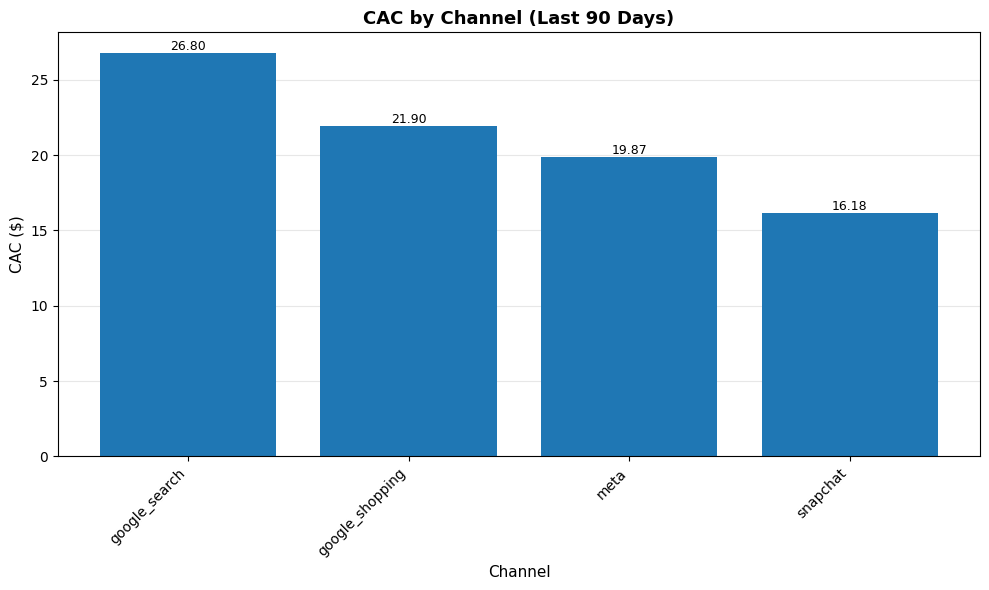

In [15]:
# Display CAC by channel
cac_df = results['cac_by_channel']['df']
print("\nCAC by Channel:")
print("=" * 60)
print(cac_df.to_string(index=False))

# Plot
fig1 = plot_channel_metric(
    cac_df,
    channel_col='channel',
    metric_col='cac',
    title=f'CAC by Channel (Last {window_days} Days)',
    ylabel='CAC ($)'
)
plt.show()

# Save
output_path = Path('./outputs')
output_path.mkdir(exist_ok=True)
fig1.savefig(output_path / f"{run_record.run_id}_cac_by_channel.png", dpi=100, bbox_inches='tight')
run_record.add_artifact('chart', str(output_path / f"{run_record.run_id}_cac_by_channel.png"))


ROAS by Channel:
        channel      spend      revenue     roas
       snapchat 1627509.78 1.109301e+07 6.815939
           meta 6466808.28 3.579672e+07 5.535453
google_shopping 1453356.97 7.266604e+06 4.999876
  google_search 7896841.26 3.235730e+07 4.097500


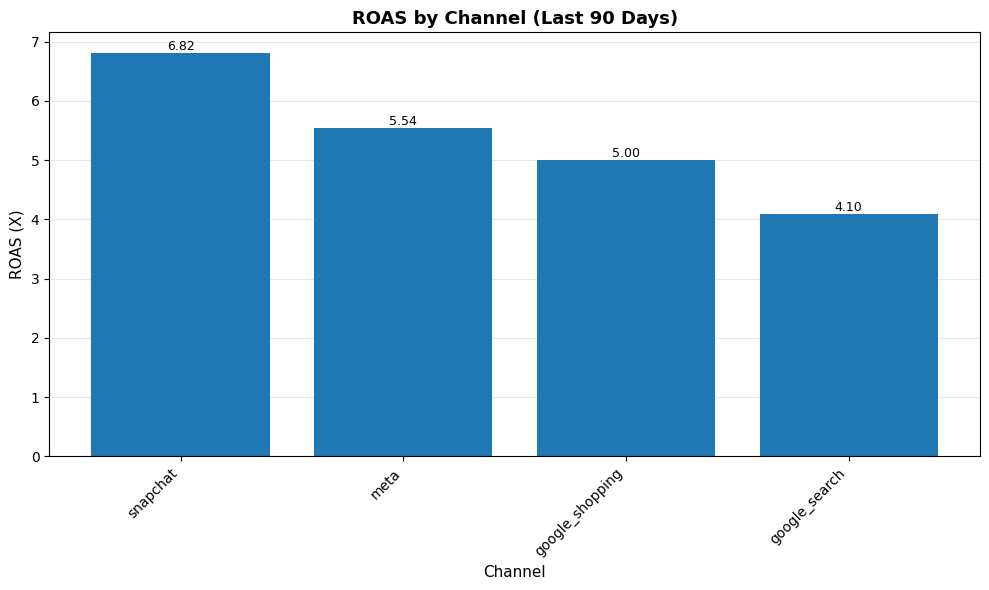

In [16]:
# Display ROAS by channel
roas_df = results['roas_by_channel']['df']
print("\nROAS by Channel:")
print("=" * 60)
print(roas_df.to_string(index=False))

# Plot
fig2 = plot_channel_metric(
    roas_df,
    channel_col='channel',
    metric_col='roas',
    title=f'ROAS by Channel (Last {window_days} Days)',
    ylabel='ROAS (X)'
)
plt.show()

# Save
fig2.savefig(output_path / f"{run_record.run_id}_roas_by_channel.png", dpi=100, bbox_inches='tight')
run_record.add_artifact('chart', str(output_path / f"{run_record.run_id}_roas_by_channel.png"))

## 7. Hypothesis Simulation

Test budget reallocation: shift 5pp from worst to best CAC channel.

In [17]:
print("Running hypothesis simulation...\n")

hypothesis_result = hypothesis_agent(cac_df)

# Record
hypothesis_params = {
    'shift_percentage': hypothesis_result['shift_percentage'],
    'n_bootstrap': hypothesis_result['n_bootstrap']
}
run_record.record_hypothesis(hypothesis_params, hypothesis_result)

print("Hypothesis Results:")
print("=" * 60)
print(f"Best channel: {hypothesis_result['best_channel']} (CAC: ${hypothesis_result['best_cac']:.2f})")
print(f"Worst channel: {hypothesis_result['worst_channel']} (CAC: ${hypothesis_result['worst_cac']:.2f})")
print(f"\nCurrent blended CAC: ${hypothesis_result['current_blended_cac']:.2f}")
print(f"Projected blended CAC: ${hypothesis_result['projected_blended_cac']:.2f}")
print(f"Expected delta: ${hypothesis_result['delta_cac']:.2f}")
print(f"\n95% Confidence Interval: [${hypothesis_result['ci_lower']:.2f}, ${hypothesis_result['ci_upper']:.2f}]")
print(f"\nRecommendation: {hypothesis_result['recommendation']}")

print("\n✓ Hypothesis simulation complete")

Running hypothesis simulation...

Hypothesis Results:
Best channel: snapchat (CAC: $16.18)
Worst channel: google_search (CAC: $26.80)

Current blended CAC: $22.83
Projected blended CAC: $22.30
Expected delta: $-0.53

95% Confidence Interval: [$19.80, $24.72]

Recommendation: Shift 5.0pp budget from google_search to snapchat

✓ Hypothesis simulation complete


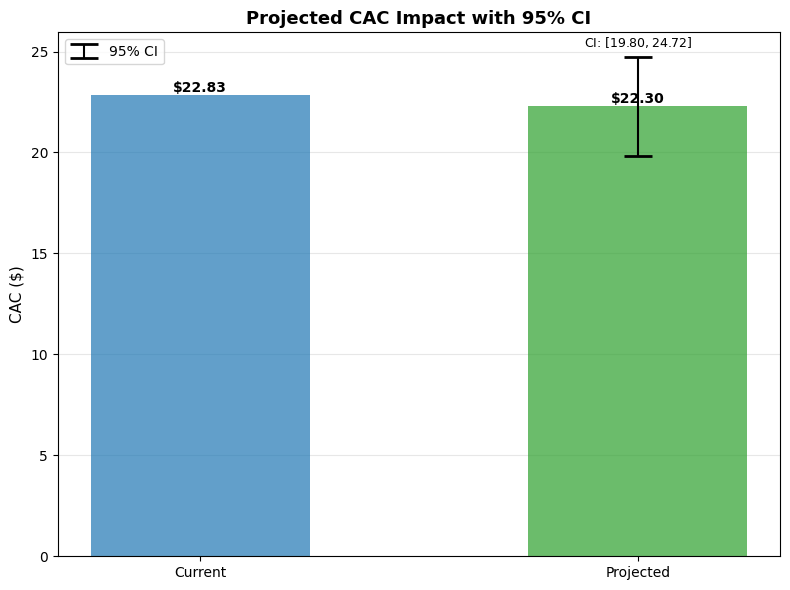

In [18]:
# Plot hypothesis
from utils.plotting import plot_hypothesis_comparison

fig3 = plot_hypothesis_comparison(
    current_cac=hypothesis_result['current_blended_cac'],
    projected_cac=hypothesis_result['projected_blended_cac'],
    ci_lower=hypothesis_result['ci_lower'],
    ci_upper=hypothesis_result['ci_upper'],
    title='Projected CAC Impact with 95% CI'
)
plt.show()

# Save
fig3.savefig(output_path / f"{run_record.run_id}_hypothesis.png", dpi=100, bbox_inches='tight')
run_record.add_artifact('chart', str(output_path / f"{run_record.run_id}_hypothesis.png"))

## 7a. Advanced: LLM-Based Hypothesis Analysis with Playbook

The bootstrap simulation above was **deterministic** (pure math, no LLM).

But what if we want the LLM to help analyze the data and propose hypotheses?

**The Challenge:** LLMs are bad at math but good at pattern recognition and reasoning.

**The Solution:** Give the LLM:
1. Pre-calculated data (we did the math)
2. Strict instructions (a "playbook")
3. Validation gates (check the output)
4. Fallback to deterministic (if LLM fails)

Let's demonstrate this with our `LLMHypothesisAgent` that uses a **hypothesis testing playbook**.

In [19]:
# Import the LLM hypothesis agent
from utils.hypothesis_testing_playbook import LLMHypothesisAgent, get_playbook

# Show the playbook (truncated for space)
playbook = get_playbook()
print("HYPOTHESIS TESTING PLAYBOOK (excerpt):")
print("=" * 80)
print(playbook[:1500] + "\n\n[... see utils/hypothesis_testing_playbook.py for full text ...]")
print("=" * 80)

HYPOTHESIS TESTING PLAYBOOK (excerpt):

# Hypothesis Testing Playbook for Marketing Budget Optimization

## Objective
Analyze channel performance data and propose a testable budget reallocation hypothesis
that is likely to improve customer acquisition cost (CAC).

## Input Data Constraints
You will receive:
1. CAC by channel (cost per conversion)
2. ROAS by channel (return on ad spend)
3. Business context (question and known anomalies)

## Analysis Requirements

### Step 1: Identify Best and Worst Performers
- BEST performers: Channels with LOW CAC and HIGH ROAS
- WORST performers: Channels with HIGH CAC and LOW ROAS
- ALWAYS cite specific numbers from the data
- DO NOT invent or assume data not provided

### Step 2: Propose Hypothesis
Your hypothesis MUST:
- Shift budget FROM worst performer TO best performer
- Specify exact percentage (between 3% and 10%)
- Follow format: "Shift X% from [channel] to [channel]"
- Be testable and reversible

INVALID hypotheses:
- ❌ "Increase budget ove

### What's in the Playbook?

The playbook contains:

1. **Clear Objective**: "Analyze channel performance and propose testable hypothesis"

2. **Input Constraints**: What data format to expect

3. **Analysis Requirements**:
   - Step 1: Identify best/worst performers (cite specific numbers)
   - Step 2: Propose hypothesis (3-10% reallocation)
   - Step 3: Calculate expected impact (weighted average formula)
   - Step 4: State confidence factors
   - Step 5: Identify risks

4. **Output Format**: Exact structure required

5. **Validation Rules**: What makes a good vs bad hypothesis

6. **Examples**: Show valid and invalid outputs

**This is what "good prompting" looks like** - not vague instructions, but a complete playbook.

In [20]:
# Initialize LLM hypothesis agent with fallback
llm_hypothesis_agent = LLMHypothesisAgent(deterministic_fallback=True)

print("Running LLM hypothesis analysis with strict playbook...\n")

# Pass the pre-calculated data to LLM
llm_hypothesis_result = llm_hypothesis_agent(
    cac_df=cac_df,
    roas_df=roas_df,
    business_question=business_question
)

print("LLM Hypothesis Analysis:")
print("=" * 80)
for key, value in llm_hypothesis_result.items():
    if key != 'method':
        print(f"\n{key.upper()}:")
        print(f"  {value}")

print("\n" + "=" * 80)
print(f"Method used: {llm_hypothesis_result['method']}")
print("=" * 80)

Running LLM hypothesis analysis with strict playbook...

LLM Hypothesis Analysis:

ANALYSIS:
  snapchat has lowest CAC at $16.18, while google_search has highest at $26.80.

HYPOTHESIS:
  Shift 5.0% from google_search to snapchat

EXPECTED_IMPACT:
  Current blended CAC: $22.83 (deterministic calculation)

CONFIDENCE_FACTORS:
  Deterministic fallback used due to LLM validation failure

RISKS:
  • LLM analysis unavailable
• Using simplified deterministic model
• May miss nuanced factors

Method used: deterministic_fallback


### Comparison: Deterministic vs LLM Hypothesis Testing

| Aspect | Deterministic (Bootstrap) | LLM (with Playbook) |
|--------|--------------------------|---------------------|
| **Analysis** | Automatic (sort by CAC) | Interprets patterns |
| **Hypothesis** | Best vs worst channel | Considers context |
| **Math** | NumPy bootstrap CI | Provided data |
| **Reasoning** | None (pure calculation) | Explains rationale |
| **Confidence** | Statistical (95% CI) | Qualitative factors |
| **Risks** | None | Lists specific risks |
| **Speed** | Very fast | Slower (API call) |
| **Cost** | Free | Small LLM cost |
| **Reliability** | 100% deterministic | Needs validation |

### When to Use Which?

**Use Deterministic when:**
- Need exact reproducibility
- Speed is critical
- Cost is a concern
- Data patterns are clear

**Use LLM when:**
- Want natural language reasoning
- Need to consider context (e.g., "recent anomaly in referral")
- Benefit from risk analysis
- Value qualitative factors

**Best Practice:** Use both!
- Deterministic for calculations
- LLM for interpretation and narrative

### Key Differences from "Bad" LLM Usage

Compare this to the bad demo:

| Bad Demo | This LLM Usage |
|----------|----------------|
| ❌ Vague prompt | ✅ Detailed playbook |
| ❌ LLM does SQL + math | ✅ LLM gets pre-calculated data |
| ❌ No validation | ✅ Validates output format |
| ❌ No fallback | ✅ Falls back to deterministic |
| ❌ Can't test | ✅ Testable with examples |
| ❌ Not observable | ✅ Logs method used |

**The LLM is a component, not the whole system.**

## 8. Narration: Generate Decision Memo

In [21]:
# Prepare inputs for narrator
metrics_used = [r['query_info']['query_id'] for r in results.values()]

key_findings = f"""
Analyzed {len(cac_df)} channels over {window_days} days. 
Best CAC: {hypothesis_result['best_channel']} at ${hypothesis_result['best_cac']:.2f}. 
Worst CAC: {hypothesis_result['worst_channel']} at ${hypothesis_result['worst_cac']:.2f}. 
Current blended CAC: ${hypothesis_result['current_blended_cac']:.2f}.
""".strip()

recommendation_text = f"""
Shift {hypothesis_result['shift_percentage']}pp budget from {hypothesis_result['worst_channel']} 
to {hypothesis_result['best_channel']}. 
Projected CAC: ${hypothesis_result['projected_blended_cac']:.2f} 
(95% CI: [${hypothesis_result['ci_lower']:.2f}, ${hypothesis_result['ci_upper']:.2f}]).
""".strip()

print("Generating decision memo...\n")

narration_result = narrator_agent(
    question=business_question,
    metrics_used=metrics_used,
    key_findings=key_findings,
    recommendation=recommendation_text
)

# Record
run_record.record_narration(narration_result['memo'])

print("Decision Memo:")
print("=" * 60)
print(narration_result['memo'])
print("\n" + "=" * 60)
print(f"Word count: {narration_result['word_count']}")
print(f"Constraints met: {narration_result.get('constraints_met', 'N/A')}")

print("\n✓ Narration complete")

Generating decision memo...

Decision Memo:
[Metrics: cac_by_channel_90d_139d34ba, roas_by_channel_90d_605a80b8] To improve our customer acquisition cost (CAC) next month, I recommend reallocating 5.0 percentage points of our budget from Google Search to Snapchat. This shift is projected to reduce our blended CAC from $22.83 to $22.30, with a 95% confidence interval of [$19.80, $24.72]. The analysis indicates Snapchat has the best performance in terms of CAC, while Google Search is currently the least efficient. However, we should monitor the impact of this change closely, as fluctuations in referral traffic could affect overall performance. Next steps include implementing the budget shift and tracking CAC metrics weekly to ensure we stay within the projected range.

Word count: 103
Constraints met: False

✓ Narration complete


## 9. Observability: Run Record

In [22]:
# Finalize run record
run_record.finalize()

# Display
print("Run Record:")
print("=" * 60)
print(run_record.to_json())
print("\n" + "=" * 60)

# Save to file
saved_path = run_record.save(output_dir='./outputs')
print(f"\n✓ Run record saved: {saved_path}")

# Summary
print("\n" + run_record.summary())

Run Record:
{
  "run_id": "run_20251110_165742_14c691",
  "start_time": "2025-11-10T16:57:42.628912",
  "end_time": "2025-11-10T17:00:43.811627",
  "environment": {
    "model_name": "gpt-4o-mini",
    "semantic_spec_hash": "3adeb316e50a"
  },
  "triage_decision": {
    "mode": "analysis",
    "confidence": 0.9,
    "reason": "Matched 4 analysis keywords",
    "method": "local_rules"
  },
  "semantic_request": {
    "metric": "cac_by_channel",
    "secondary_metrics": [
      "roas_by_channel"
    ],
    "dimensions": [
      "channel"
    ],
    "filters": {},
    "window_days": 90,
    "method": "pattern_match",
    "reason": "CAC optimization requires both CAC and ROAS by channel"
  },
  "compiled_queries": [
    {
      "query_id": "cac_by_channel_90d_139d34ba",
      "metric": "cac_by_channel",
      "window_days": 90,
      "spec_hash": "3adeb316e50a"
    },
    {
      "query_id": "roas_by_channel_90d_605a80b8",
      "metric": "roas_by_channel",
      "window_days": 90,
      "

## 10. Inline Tests and Smoke Checks

In [23]:
print("Running inline tests...\n")

# Test 1: Schema presence
try:
    schema_check = validate_schema(conn)
    run_record.record_test('schema_validation', True, 'All required tables and columns present')
    print("✓ Test 1: Schema validation passed")
except Exception as e:
    run_record.record_test('schema_validation', False, str(e))
    print(f"✗ Test 1: Schema validation failed: {e}")

# Test 2: SQL compilation for derived metrics
try:
    for metric in ['roas_by_channel', 'cac_by_channel']:
        compiled = semantic.compile_query(metric, DEFAULT_WINDOW_DAYS)
        assert 'sql' in compiled
        assert len(compiled['sql']) > 0
    run_record.record_test('sql_compilation', True, 'Both derived metrics compile successfully')
    print("✓ Test 2: SQL compilation passed")
except Exception as e:
    run_record.record_test('sql_compilation', False, str(e))
    print(f"✗ Test 2: SQL compilation failed: {e}")

# Test 3: No cartesian explosion (channel count sanity)
try:
    expected_max_channels = 10  # Reasonable upper bound
    for metric, result in results.items():
        row_count = result['row_count']
        assert row_count <= expected_max_channels, f"{metric} returned {row_count} rows (expected <= {expected_max_channels})"
    run_record.record_test('no_cartesian_explosion', True, f'All queries returned <= {expected_max_channels} rows')
    print("✓ Test 3: No cartesian explosion")
except Exception as e:
    run_record.record_test('no_cartesian_explosion', False, str(e))
    print(f"✗ Test 3: Cartesian explosion detected: {e}")

# Test 4: Triage accuracy on canned queries
try:
    test_cases = [
        ('What is the CAC by channel?', 'analysis'),
        ('Show me campaign performance', 'analysis'),
        ('Which channel should I optimize?', 'analysis'),
        ('List all campaigns', 'search'),
    ]
    correct = 0
    for query, expected_mode in test_cases:
        result = triage_agent(query)
        if result['mode'] == expected_mode:
            correct += 1
    
    accuracy = correct / len(test_cases)
    threshold = 0.75
    passed = accuracy >= threshold
    run_record.record_test('triage_accuracy', passed, f'Accuracy: {accuracy:.2%} (threshold: {threshold:.2%})')
    if passed:
        print(f"✓ Test 4: Triage accuracy {accuracy:.2%} >= {threshold:.2%}")
    else:
        print(f"✗ Test 4: Triage accuracy {accuracy:.2%} < {threshold:.2%}")
except Exception as e:
    run_record.record_test('triage_accuracy', False, str(e))
    print(f"✗ Test 4: Triage accuracy test failed: {e}")

# Test 5: Narration lint (length and metric reference)
try:
    memo = narration_result['memo']
    word_count = narration_result['word_count']
    
    # Check word count
    assert word_count <= 200, f"Narration too long: {word_count} words"
    
    # Check metric reference
    memo_lower = memo.lower()
    metric_referenced = any(m.lower() in memo_lower for m in metrics_used) or 'cac' in memo_lower or 'roas' in memo_lower
    assert metric_referenced, "Narration does not reference any metrics"
    
    run_record.record_test('narration_lint', True, f'Word count: {word_count}, metric referenced: {metric_referenced}')
    print(f"✓ Test 5: Narration lint passed ({word_count} words, metric referenced)")
except AssertionError as e:
    run_record.record_test('narration_lint', False, str(e))
    print(f"✗ Test 5: Narration lint failed: {e}")
except Exception as e:
    run_record.record_test('narration_lint', False, str(e))
    print(f"✗ Test 5: Narration lint error: {e}")

# Summary
total_tests = len(run_record.test_results)
passed_tests = sum(1 for t in run_record.test_results.values() if t['passed'])
print(f"\n{'=' * 60}")
print(f"Tests passed: {passed_tests}/{total_tests}")
print(f"{'=' * 60}")

Running inline tests...

✓ Test 1: Schema validation passed
✓ Test 2: SQL compilation passed
✓ Test 3: No cartesian explosion
✓ Test 4: Triage accuracy 100.00% >= 75.00%
✓ Test 5: Narration lint passed (103 words, metric referenced)

Tests passed: 5/5


## Summary: What We Built

### Architecture Components

1. **Semantic Layer** (`config/semantic.yml`)
   - Canonical metric definitions
   - Safe, tested base queries
   - Join rules enforced
   - Versioned with hash

2. **Modular Agents** (DSPy signatures)
   - TriageAgent: Local rules + LLM fallback
   - TextToSemanticAgent: Template matching + constrained LLM
   - MetricRunner: Deterministic SQL compilation
   - HypothesisAgent: Bootstrap confidence intervals
   - NarratorAgent: Structured output with constraints

3. **Observability**
   - Unique run_id for every execution
   - All decisions logged with provenance
   - Timings, row counts, SQL IDs tracked
   - Artifacts (charts, data) referenced
   - Test results recorded

### Key Differences from Bad Demo

| Bad Demo | Good Demo |
|----------|----------|
| One-shot LLM on raw data | Modular agents with semantic layer |
| No validation | Schema validation, sanity checks, tests |
| Wrong joins, time windows | Enforced in semantic.yml |
| No confidence intervals | Bootstrap CI for projections |
| Overconfident narratives | Constrained output with risks |
| No reproducibility | Full observability with run_id |

### Production-Ready Features

- ✓ All data access through semantic layer
- ✓ LLM used only for ambiguity resolution
- ✓ Deterministic logic wherever possible
- ✓ Comprehensive testing and validation
- ✓ Full observability and reproducibility
- ✓ Quantified uncertainty (confidence intervals)
- ✓ Clear decision memos with risks and next steps

In [22]:
# Cleanup
conn.close()
print("\n✓ Demo complete. Database connection closed.")
print(f"\nAll artifacts saved to: {output_path.absolute()}")


✓ Demo complete. Database connection closed.

All artifacts saved to: /Users/thomas/Documents/GitHub/tasman-marketing-agent/demo/outputs
